In [1]:
driver_name = '../'

In [2]:
import numpy as np
import pandas as pd
from pandas import concat

from collections import OrderedDict
import requests
from sklearn.externals import joblib

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, DataStructs, Draw
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint, GetMorganFingerprintAsBitVect
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger
RDLogger.logger().setLevel(RDLogger.CRITICAL)

C:\ProgramData\Anaconda3\envs\rdkit\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
morgan_nb = joblib.load( driver_name + 'data/chembl_25/models/10uM/mNB_10uM_all.pkl')
classes = list( morgan_nb.targets )
len( classes )

C:\ProgramData\Anaconda3\envs\rdkit\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.19.1 when using version 0.22.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\envs\rdkit\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\envs\rdkit\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.1 when using version 0.22.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\env

1649

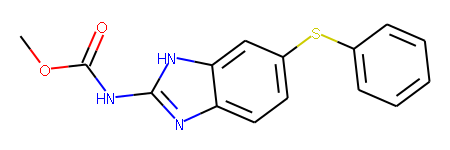

In [4]:
smiles = 'O[C@@H](CNCCCC#CC1=CC=C(C=C1)NC(=O)C=1C=C(C=CC1)S(=O)(=O)C=1C=C2C(=C(C=NC2=C(C1)C)C(=O)N)NC1=CC(=CC=C1)OC)C1=C2C=CC(NC2=C(C=C1)O)=O'
smiles = 'COC(=O)Nc3nc2ccc(Sc1ccccc1)cc2[nH]3'  # penbendazole
mol = Chem.MolFromSmiles(smiles)
mol

In [5]:
bitinfo={}
fp = AllChem.GetMorganFingerprintAsBitVect( mol, 2, nBits=2048, bitInfo=bitinfo )
fps = np.zeros( len(fp), np.int32 )
DataStructs.ConvertToNumpyArray( fp, fps )

probas = list(morgan_nb.predict_proba( fps.reshape(1,-1) )[0])
predictions = pd.DataFrame( zip(classes, probas), columns=['id','proba'] )
top_preds = predictions.sort_values( by='proba', ascending=False ).head(10)
top_preds

id     proba
169      CHEMBL1906  0.999999
915      CHEMBL3658  0.998259
1410     CHEMBL5145  0.997917
1110     CHEMBL4128  0.987022
206      CHEMBL1952  0.981624
1635     CHEMBL6137  0.945255
60    CHEMBL1293277  0.753855
53    CHEMBL1293231  0.409786
788      CHEMBL3356  0.337884
897      CHEMBL3622  0.319159

In [6]:
def fetch_WS(trgt):
    res = requests.get('https://www.ebi.ac.uk/chembl/api/data/target/{0}.json'.format(trgt))
    return (trgt, res.json()['pref_name'], res.json()['organism'])


target_list = []
for i,e in enumerate( top_preds[ 'id' ] ):
    target_list.append( fetch_WS(e) )


target_info = pd.DataFrame( target_list, columns =['id','name', 'organism'] )
pd.merge(top_preds, target_info)

id     proba                                   name  \
0     CHEMBL1906  0.999999    Serine/threonine-protein kinase RAF   
1     CHEMBL3658  0.998259                    Tubulin alpha chain   
2     CHEMBL5145  0.997917  Serine/threonine-protein kinase B-raf   
3     CHEMBL4128  0.987022          Tyrosine-protein kinase TIE-2   
4     CHEMBL1952  0.981624                   Thymidylate synthase   
5     CHEMBL6137  0.945255                   Thymidylate synthase   
6  CHEMBL1293277  0.753855                Niemann-Pick C1 protein   
7  CHEMBL1293231  0.409786             Nuclear receptor ROR-gamma   
8     CHEMBL3356  0.337884                    Cytochrome P450 1A2   
9     CHEMBL3622  0.319159                   Cytochrome P450 2C19   

           organism  
0      Homo sapiens  
1        Sus scrofa  
2      Homo sapiens  
3      Homo sapiens  
4      Homo sapiens  
5  Escherichia coli  
6      Homo sapiens  
7      Mus musculus  
8      Homo sapiens  
9      Homo sapiens